In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [22]:
# View all of the classes that automap found
classes = base.classes
tables = classes.keys()
tables

['measurement', 'station']

In [23]:
# Save references to each table
table_references = {}
for table, table_class in classes.items():
    table_references[table] = table_class
table_references

measurement = classes['measurement']
station = classes['station']



In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date

'2017-08-23'

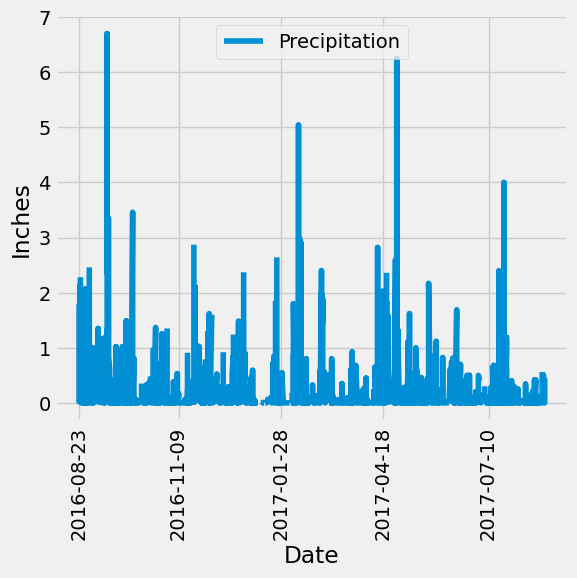

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#most_recent_date
# Calculate the date one year from the last date in data set.
#one_year_from_last_date
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ['Date', 'Precipitation']
one_year_df = pd.DataFrame(precipitation_data, columns=column_names)

# Sort the dataframe by date
one_year_df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(6,6))
plt.plot(one_year_df['Date'], one_year_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')

specific_dates = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(specific_dates,rotation=90)

plt.legend(loc= 'upper center')
plt.tight_layout()
plt.show()

In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = pd.DataFrame(one_year_df['Precipitation'].describe())
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()
station_list = [tuple(row) for row in most_active_stations]
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = station_list[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs).label('min_temp'),
                                  func.max(measurement.tobs).label('max_temp'),
                                  func.avg(measurement.tobs).label('avg_temp'))\
                           .filter(measurement.station == most_active_station_id)\
                           .all()

temperature_stats_list = [(temperature_stats[0].min_temp,
                            temperature_stats[0].max_temp,
                            temperature_stats[0].avg_temp)]

temperature_stats_list

[(54.0, 85.0, 71.66378066378067)]

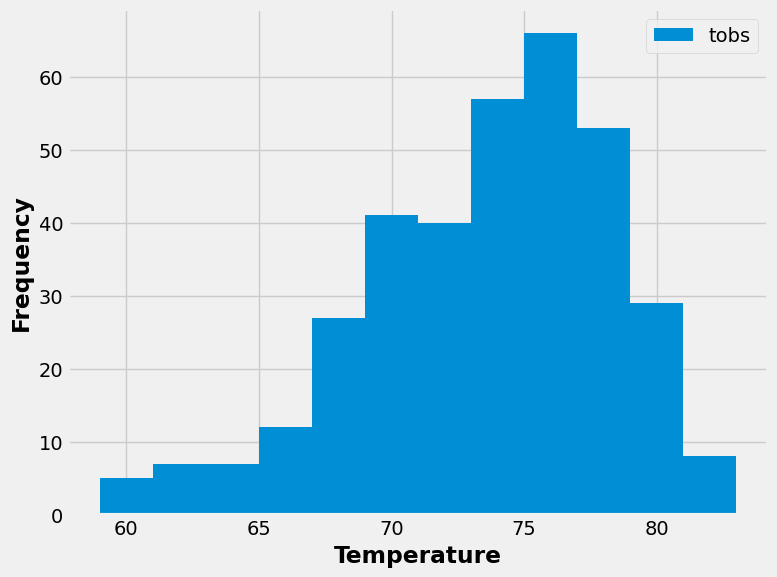

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.tobs)\
                          .filter(measurement.station == most_active_station_id,
                                  measurement.date >= one_year_ago.strftime('%Y-%m-%d'))\
                          .all()
# Save the query results as a list
temperature_list = [temp[0] for temp in temperature_data]

plt.figure(figsize=(8, 6))
plt.hist(temperature_list, bins=12, label='tobs')
plt.xlabel('Temperature', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.tight_layout()
plt.legend()
plt.show()



# Close Session

In [32]:
# Close Session
session.close()